### <b> This chapter focuses on the MNIST dataset. A dataset that is commonly referred to as the "hello world" of Machine Learning </b>

In [1]:
' Import the MNIST dataset'
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
' Inspect the arrays'
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


<b> The arrays are 70,000 rows with 784 features.  By default they are flattened 28x28 arrays of pixel intensity values which represent an image. </b>

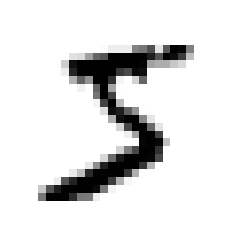

Target value:  5


In [3]:
' Observe the image represented in the first item of the data array'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

digit = X.to_numpy()[0].reshape(28,28)
plt.imshow(digit, cmap='binary')
plt.axis('off')
plt.show()
print('Target value: ', y.to_numpy()[0])

In [4]:
' Convert the labels from strings to integers'
import numpy as np
y = y.astype(np.uint8)
y.describe

<bound method NDFrame.describe of 0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8>

<b> By design the MNIST dataset is already split into a train and a test set.  The first 60,000 samples represent a shuffled training set and the remaining 10,000 are the test set. </b>

In [5]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

<b> Training a Binary Classifier </b>

In [6]:
' To begin, simplify the problem to identify only a single digit. 5 and not-5.'

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

 #### A quick note about the SGD classifer ###
    
The Stochastic Gradient Descent (SGD) classifer deals with training instances independently, one at a time. This makes it well suited for both online learning and very large datasets. It relies on randomness during training and for replicable results its important to set a random_state parameter

In [7]:
' Train a SGD classifer'
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([digit.flatten()])

array([ True])

<b> Evaluating a classifier is trickier than evaluating a regressor. As such a large section of this chapter will be devoted to methods used in evaluting classifiers </b>

#### Cross Validation

In [8]:
'''
    Sometimes you might want more control over the cross_validation process than what sklearn provides.  Understanding whats going on under the hood is important. 
    The following is an example of a loop which does roughly the same thing as sklearns cross_val_score() function
'''

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
# The StratifiedKFold class performs stratified sampling to produce folds that contain the representative ratio of each class.
# At each iteration the code creates a clone of the classifer, trains that clone on the training folds, then makes predictions on the test fold.
# Finally it displays the ratio of correct predictions as the final accuracy

0.9669
0.91625
0.96785


In [9]:
' Compare the manual cross validation loop with the results from sklearn cross_val_scoare'
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

<b> As always if the accuracy of the model seems to good to be true it likely is.  In this case the reason the accuracy is so high is that the composition of 5's in the dataset represent about 10% of the data.  As such, the model learns very quickkly that classifying everything as "not-5" yields very good results. This is a reason why accuracy is often not the preferred metric for classification performance, especially with skewed datasets where some values appear more often than others. </b>

In [10]:
' Compare the model results with that of a classifier which only returns False'
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

#### Confusion Matrix

<b>Confustion matrices compare the predictions of a classifier into True Positives, True Negatives, False Positives, and  False Negatives. They are a much better tool for measuring a classifiers predictive ability than accuracy alone.</b>

In [11]:
' Construct a confustion matrix using sklearns cross_val_predict and confustion_matrix functions'
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, n_jobs= -1)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

<b> The True values lie along the diagonal. False negatives lie below the diagonal and false positives lie above it.</b>

<b> While the confusion matrix is a powerful tool and is superior than a simple accuracy score, a combination of <i> precision </i> and <i> recall </i> can provide a more concise metric for measuring the performance of the classifier </b>

#### Precision and Recall

$$ Precision = \frac{True Positives}{(True Positives + False Positives)} $$

$$ Recall = \frac{True Positives}{(True Positives + False Negatives)} $$

In [12]:
' Apply precision and recall to the binary classifier'
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print (precision, recall)

0.8370879772350012 0.6511713705958311


<b> This classifer predicts an image of a 5 correctly 83.7% of the time, and out of all of the 5s in the dataset it detects 65.1% of them. Having very high values of precision and recall is very difficult in practice and often you need to choose which one is more important for your application.  A useful metric for comparing predicitve power of various classifiers is the $F_{1}$ score.  The $F_{1}$ score favors classifiers with similar precision and recall and as mentioned before that isn't always what you want. </b>

$$ F_{1} = \frac{True Positives}{True Positives + \frac{(False Negatives + False Positives)}{2}} $$

In [13]:
' Apply the F1 score to the binary classifier'
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision / Recall Trade-off

<b> Although sklearn doesn't allow you to directly adjust the threshold it uses to make predictions it does allow you to return the decision function score for each element of the dataset.  This allows you to manually determine the threshold for predictions </b>

In [14]:
' Show that the default threshold for the SGDClassifer is 0'
digit = digit.flatten()
y_scores = sgd_clf.decision_function([digit])
y_scores

array([2164.22030239])

In [15]:
threshold = 0
y_digit_pred = (y_scores > threshold)
y_digit_pred
# This isn't a rigorous analysis.  There's no way to know if the default threshold is 1, or 2, or 2163.  But the library API tells us the default is 0

array([ True])

In [16]:
' Demonstrate a manually chosen threshold'
threshold = 8000
y_digit_pred = (y_scores > threshold)
y_digit_pred
# This is one example showing that raising the threshold reduces the recall

array([False])

<b> How do you decide which threshold to use? Frankly, that depends on the problem you're solving.  In some cases precision addresses the goal better than recall, and in others a high recall percent is preferred.  However, there is a methodical process to determine critical values in either case </b>

#### Precision - Recall curve

In [17]:
' First use sklearns cross_val_predict function but set the "method" paramter to "decision_function" to return the prediction scores instead of their transformed predictions'
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [18]:
' Next use sklearns precision_recall_curve function to generate the plot values'
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

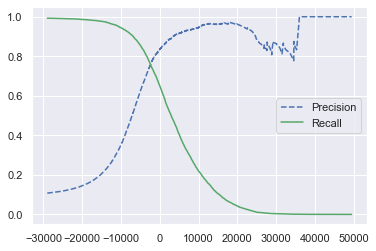

In [19]:
' Then plot the values to observe the curves'
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds[-50000:], precisions[-50000:], 'b--', label='Precision')
    plt.plot(thresholds[-50000:], recalls[-50000:], 'g-', label='Recall')
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

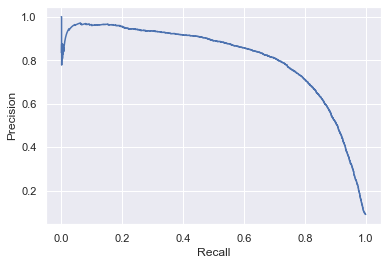

In [20]:
' Alternatively you can plot precision directly against recall to visualize the trade-off'
plt.plot(recalls, precisions)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [21]:
' To be more precise you can search for the lowest threshold that gives you at least x% precision'
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
p_score = precision_score(y_train_5, y_train_pred_90)
r_score = recall_score(y_train_5, y_train_pred_90)
print(threshold_90_precision, p_score, r_score)

3370.0194991439557 0.9000345901072293 0.4799852425751706


<b> A high precision model isn't very useful if its recall is too low! </b>

#### The ROC Curve

<b> The <i> Receiver Operating Characteristic </i> (ROC) curve is another common tool used with binary classifiers. Recall = True Positive Rate (TPR) divided by False Positive Rate (FPR)</b>

$$ROC = \frac{Recall}{1 - \frac{True Negavites}{Total Negative Samples}}$$

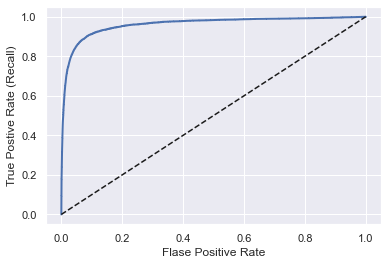

In [22]:
' Plot the ROC curve'
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plt.plot(fpr, tpr, linewidth=2, label='ROC')
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Postive Rate (Recall)')
plt.plot([0,1], [0,1], 'k--')
plt.show()

<b> A good classifier stays as far toward the top-left corner as possible </b>

<b> Since the ROC curve is so simliar to the precision/recall curve its not always certain which to use when.  As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.  Otherwise, use the ROC curve </b>

In [23]:
' Train a RandomForestClassifier and compare its ROC curve to the SGDClassifier'
# Random Forests use predict_proba() instead of decision_function but otherwise the syntax is the same
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

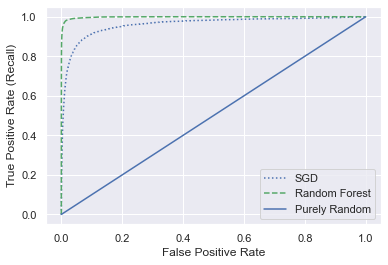

In [24]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, 'g--', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.plot([0,1], [0,1], 'b-', label='Purely Random')
plt.legend()
plt.show()

<b> Comparing the ROC curves shows the Random Forest is superior to the SGD </b>

In [25]:
' Check the precision and recall scores for the Random Forest'

forest_pred = (y_scores_forest > 0.5)
p_score = precision_score(y_train_5, forest_pred)
r_score = recall_score(y_train_5, forest_pred)

print(p_score, r_score) #IMPRESSIVE!

0.9905083315756169 0.8662608374838591


#### Multiclasss Classification

<b> Not all classifiers can handle non-binary outputs.  Some, like SGD, Random Forest, and naive Bayes can but others require different tricks to handle multiclass classification.  Tricks like <i> one-versus-one (OvO)</i> and <i> one-versus-the-rest (OvR) </i> essentially build n-different binary classification models and select the class with the highest score among all models, for example. In most cases OvR is preferred. </b>

In [26]:
' Luckily, sklearn can detect when you are attemping multiclass classification and will automatically run OvR or OvO operations'
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([digit])

array([5], dtype=uint8)

In [27]:
' Under the hood the SVC applied 45 different one-verus-one models and scored each class with 10 models. It then chose the highest score as the output'
score = svm_clf.decision_function([digit])
score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [28]:
' The highest score was indeed representative of 5'
print ('Index value of class: ', np.argmax(score), '\n', 'List of possible classes: ', svm_clf.classes_)

Index value of class:  5 
 List of possible classes:  [0 1 2 3 4 5 6 7 8 9]


In [29]:
' Its possible to direct sklearn to run an OvO or OvR by importing the relevant class'
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([digit])

array([5], dtype=uint8)

In [30]:
' Other classifiers are capable of handling multiclassification natively.'
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([digit])

array([3], dtype=uint8)

In [31]:
' Observe the scoring'
sgd_clf.decision_function([digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [32]:
' Apply cross-validation to see if the result improves'
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [33]:
' As usual machine learning models benefit from scaled features'
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

#### Error Analysis

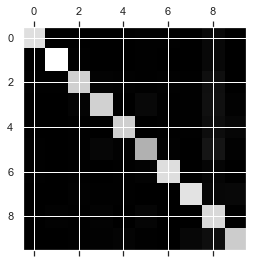

In [34]:
" A useful visualization representing a classifier's weaknesses is a modified confusion matrix which displays a ratio of incorrect predictions to total instances of each class."
y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train_scaled, y=y_train, cv=3, n_jobs= -1)
conf_matrix = confusion_matrix(y_train, y_train_pred)

# More often than not its better to visualize the confusion matrix as a heatmap
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

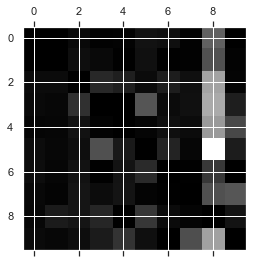

In [35]:
' Modify the confusion matrix to better highlight errors'
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums

# Fill the diagonal with 0's because we don't care about correct predictions, we want to isolate errors and weaknesses
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

<b> The column for class 8 is quite bright, which tells you that many images get misclassified as 8s.  However, the row for class 8 is not so bright, tell you that actual 8's in general get properly classified as 8s.  You can also see 3s and 5s tend to be misclassified quite a bit. <b>

<b> There are two things you can do to improve this classifier.  Primarily, you should focus on improving its ability differentiate 8s.  Second, you can look into the 3s and 5s and try to find something you can engineer to reduce that confusion <b>

In [43]:
' EXTRA copy-paste from this chapters jupyter notebook. Found in my GitHub hanson folder'
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

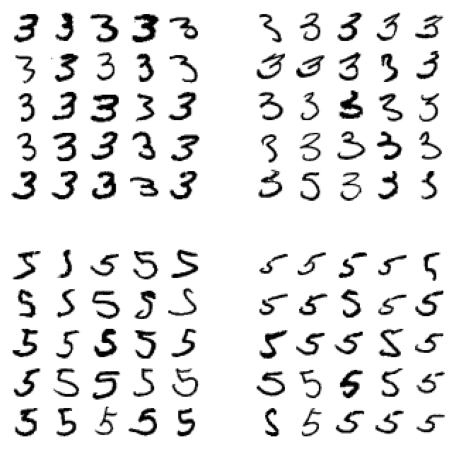

In [44]:
' Some advanced use of matplotlib copied from this chapters jupyter book allows us to plot some examples of 3s and 5s in a concise way'
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # correctly predicted 3s as 3s
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # incorrectly predicted 3s as 5s
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # incorrectly predicted 5s as 3s
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # correctly predicted 5s as 5s

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

<b> The two 5x5 blocks on the left show digits classified as 3s, and the two 5x5 blocks on the right show images classified as 5s <b>

<b> It takes a deep understanding of how a SGDClassifer works to really comprehend why its making the mistakes it makes.  The author explains that because the SGDClassifier is a linear model it assigns 1 weight per class to each pixel in the image and when it sees a new image it sums up the weighted pixel intensities to get a score for each class.  So since 3s and 5s differ onl by a few pixels, this model easily confuses them.  Note that the primary difference in the shape of a 3 and 5 is the location of the top-most vertical line connecting the bottom portion of the shape to the top portion. <b>